In [9]:
import os
import numpy as np
from PIL import Image
from einops import rearrange
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms


class SegmentationDataset(Dataset):
    def __init__(self, config, mode):
        assert mode in {"train", "valid", "test"}
        self.config = config
        self.root_dir = self.config["root_dir"]
        self.mode = mode

        self.resize_height = config["resize_height"]
        self.resize_width = config["resize_width"]

        self.image_transform = transforms.Compose(
            [
                transforms.Resize((self.resize_height, self.resize_width)),
                transforms.ToTensor(),
            ]
        )

        self.get_filenames()

    def get_filenames(self):
        self.images_training_dir = os.path.join(self.root_dir, "images", "training")
        self.annotations_training_dir = os.path.join(
            self.root_dir, "annotations", "training"
        )

        self.images_validation_dir = os.path.join(self.root_dir, "images", "validation")
        self.annotations_validation_dir = os.path.join(
            self.root_dir, "annotations", "validation"
        )

        train_images = sorted(
            [f for f in os.listdir(self.images_training_dir) if f.endswith(".jpg")]
        )
        train_masks = sorted(
            [f for f in os.listdir(self.annotations_training_dir) if f.endswith(".png")]
        )

        val_images = sorted(
            [f for f in os.listdir(self.images_validation_dir) if f.endswith(".jpg")]
        )
        val_masks = sorted(
            [
                f
                for f in os.listdir(self.annotations_validation_dir)
                if f.endswith(".png")
            ]
        )

        if self.mode == "train":
            self.images, self.masks = train_images, train_masks
            self.images_path, self.masks_path = (
                self.images_training_dir,
                self.annotations_training_dir,
            )
        else:
            self.images, self.masks = val_images, val_masks
            self.images_path, self.masks_path = (
                self.images_validation_dir,
                self.annotations_validation_dir,
            )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx].split("/")[-1].split(".")[0]

        image_path = os.path.join(self.images_path, f"{image_name}.jpg")
        mask_path = os.path.join(self.masks_path, f"{image_name}.png")

        # Load image and apply transform
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        # Load and resize mask without normalization
        mask = Image.open(mask_path)
        mask = mask.resize(
            (self.resize_width, self.resize_height), resample=Image.NEAREST
        )
        mask = torch.from_numpy(np.array(mask)).long()  # shape: [H, W]

        return {
            "image": image,
            "mask": mask,
            "image_filepath": image_path,
            "mask_filepath": mask_path,
        }


class SimpleSegDataset(SegmentationDataset):
    def __getitem__(self, *args, **kwargs):
        return super().__getitem__(*args, **kwargs)

In [10]:
DATA_ROOT_DIR = "DEIT-III/images/ADEChallengeData2016"

config = {
    "root_dir": DATA_ROOT_DIR,
    "resize_height": 224,
    "resize_width": 224,
    "batch_size": 1,
    "num_workers": 0,
}

In [12]:
train_dataset = SimpleSegDataset(config=config, mode="train")
valid_dataset = SimpleSegDataset(config=config, mode="valid")


train_loader = DataLoader(
    train_dataset,
    batch_size=1,  # adjust as needed
    shuffle=True,
    num_workers=0,  # set 0 if you're on Windows or debugging
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

In [23]:
sample = valid_dataset[0]
print(sample.keys())
print()
print(sample["image_filepath"])  # path to the image
print(sample["mask_filepath"])  # path to the mask
print()
print(sample["image"].shape)  # [3, 224, 224]
print(sample["mask"].shape)  # [224, 224]
# print unique values in the mask
print(torch.unique(sample["mask"]))  # should be 0-150 for ADE20K

dict_keys(['image', 'mask', 'image_filepath', 'mask_filepath'])

DEIT-III/images/ADEChallengeData2016\images\validation\ADE_val_00000001.jpg
DEIT-III/images/ADEChallengeData2016\annotations\validation\ADE_val_00000001.png

torch.Size([3, 224, 224])
torch.Size([224, 224])
tensor([ 0,  1,  2,  3,  5,  7, 10, 18])


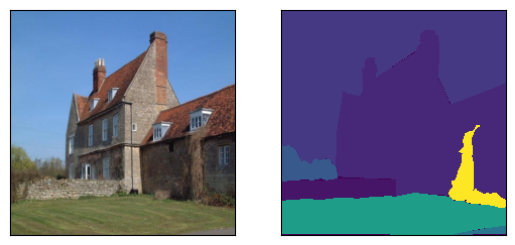

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function for data visualization
def visualize_image_mask(sample):
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        sample["image"].numpy().transpose(1, 2, 0)
    )  # for visualization we have to transpose back to HWC
    plt.subplot(1, 2, 2)
    # Turn off tick labels
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        sample["mask"].squeeze()
    )  # for visualization we have to remove 3rd dimension of mask
    plt.show()


visualize_image_mask(sample)

In [26]:
# print all to be visible
print(sample["mask"])

tensor([[ 3,  3,  3,  ...,  0,  0,  0],
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        ...,
        [10, 10, 10,  ...,  7,  7,  7],
        [10, 10, 10,  ...,  7,  7,  7],
        [ 0,  0,  0,  ...,  0,  0,  0]])


In [ ]:
# # check the number of classes in the dataset
# max_mask_value = 0
# for data in valid_loader:
#     mask = data["mask"]
#     max_mask_value = max(max_mask_value, mask.max().item())

# print(f"Max mask value: {max_mask_value}")  # should be 150 - checked 

Max mask value: 150
